In [7]:
%cd ..

/home/coder/project/models/object_detection/yolov7


In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml
from detectron2.layers import paste_masks_in_image
from detectron2.modeling.poolers import ROIPooler
from detectron2.structures import Boxes
from detectron2.utils.memory import retry_if_cuda_oom
from torchvision import transforms
from utils.datasets import letterbox
from utils.general import non_max_suppression_mask_conf

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
with open('data/hyp.scratch.mask.yaml') as f:
    hyp = yaml.load(f, Loader=yaml.FullLoader)
weigths = torch.load('./weights/yolov7-mask.pt')
model = weigths['model']
model = model.half().to(device)
_ = model.eval()

In [10]:
image = cv2.imread("./inference/images/bus.jpg")  # 504x378 image
image = letterbox(image, 640, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))
image = image.to(device)
image = image.half()

output = model(image)


/root/.pyenv/versions/3.9.13/envs/torch/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
/root/.pyenv/versions/3.9.13/envs/torch/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
inf_out, train_out, attn, mask_iou, bases, sem_output = (
    output["test"],
    output["bbox_and_cls"],
    output["attn"],
    output["mask_iou"],
    output["bases"],
    output["sem"],
)

In [12]:
inf_out.shape, attn.shape, bases.shape, sem_output.shape

(torch.Size([1, 20160, 85]),
 torch.Size([1, 20160, 980]),
 torch.Size([1, 4, 160, 128]),
 torch.Size([1, 1, 160, 128]))

In [13]:
print(bases.shape)
print(sem_output.shape)
bases = torch.cat([bases, sem_output], dim=1)
print(bases.shape)
nb, _, height, width = image.shape
names = model.names
pooler_scale = model.pooler_scale
pooler = ROIPooler(
    output_size=hyp["mask_resolution"],
    scales=(pooler_scale,),
    sampling_ratio=1,
    pooler_type="ROIAlignV2",
    canonical_level=2,
)

torch.Size([1, 4, 160, 128])
torch.Size([1, 1, 160, 128])
torch.Size([1, 5, 160, 128])


In [14]:
output, output_mask, output_mask_score, output_ac, output_ab = non_max_suppression_mask_conf(
    inf_out, attn, bases, pooler, hyp, conf_thres=0.25, iou_thres=0.65, merge=False, mask_iou=None
)

A
torch.Size([1, 5, 160, 128])
torch.Size([61, 4])
B
torch.Size([61, 5, 56, 56])
torch.Size([61, 980])
C
torch.Size([61, 3136])


In [23]:
pred, pred_masks = output[0], output_mask[0]
# base = bases[0]
bboxes = Boxes(pred[:, :4])
original_pred_masks = pred_masks.view(-1, hyp["mask_resolution"], hyp["mask_resolution"])
pred_masks = retry_if_cuda_oom(paste_masks_in_image)(
    original_pred_masks, bboxes, (height, width), threshold=0.5
)
pred_masks_np = pred_masks.detach().cpu().numpy()
pred_cls = pred[:, 5].detach().cpu().numpy()
pred_conf = pred[:, 4].detach().cpu().numpy()
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
nbboxes = bboxes.tensor.detach().cpu().numpy().astype(np.int)
pnimg = nimg.copy()

/tmp/ipykernel_38078/1997878899.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nbboxes = bboxes.tensor.detach().cpu().numpy().astype(np.int)


In [24]:
for one_mask, bbox, cls, conf in zip(pred_masks_np, nbboxes, pred_cls, pred_conf):
    if conf < 0.25:
        continue

    color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

    pnimg[one_mask] = pnimg[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5
    # pnimg = cv2.rectangle(pnimg, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)
    # label = '%s %.3f' % (names[int(cls)], conf)
    # t_size = cv2.getTextSize(label, 0, fontScale=0.5, thickness=1)[0]
    # c2 = bbox[0] + t_size[0], bbox[1] - t_size[1] - 3
    # pnimg = cv2.rectangle(pnimg, (bbox[0], bbox[1]), c2, color, -1, cv2.LINE_AA)  # filled
    # pnimg = cv2.putText(pnimg, label, (bbox[0], bbox[1] - 2), 0, 0.5, [255, 255, 255], thickness=1, lineType=cv2.LINE_AA)


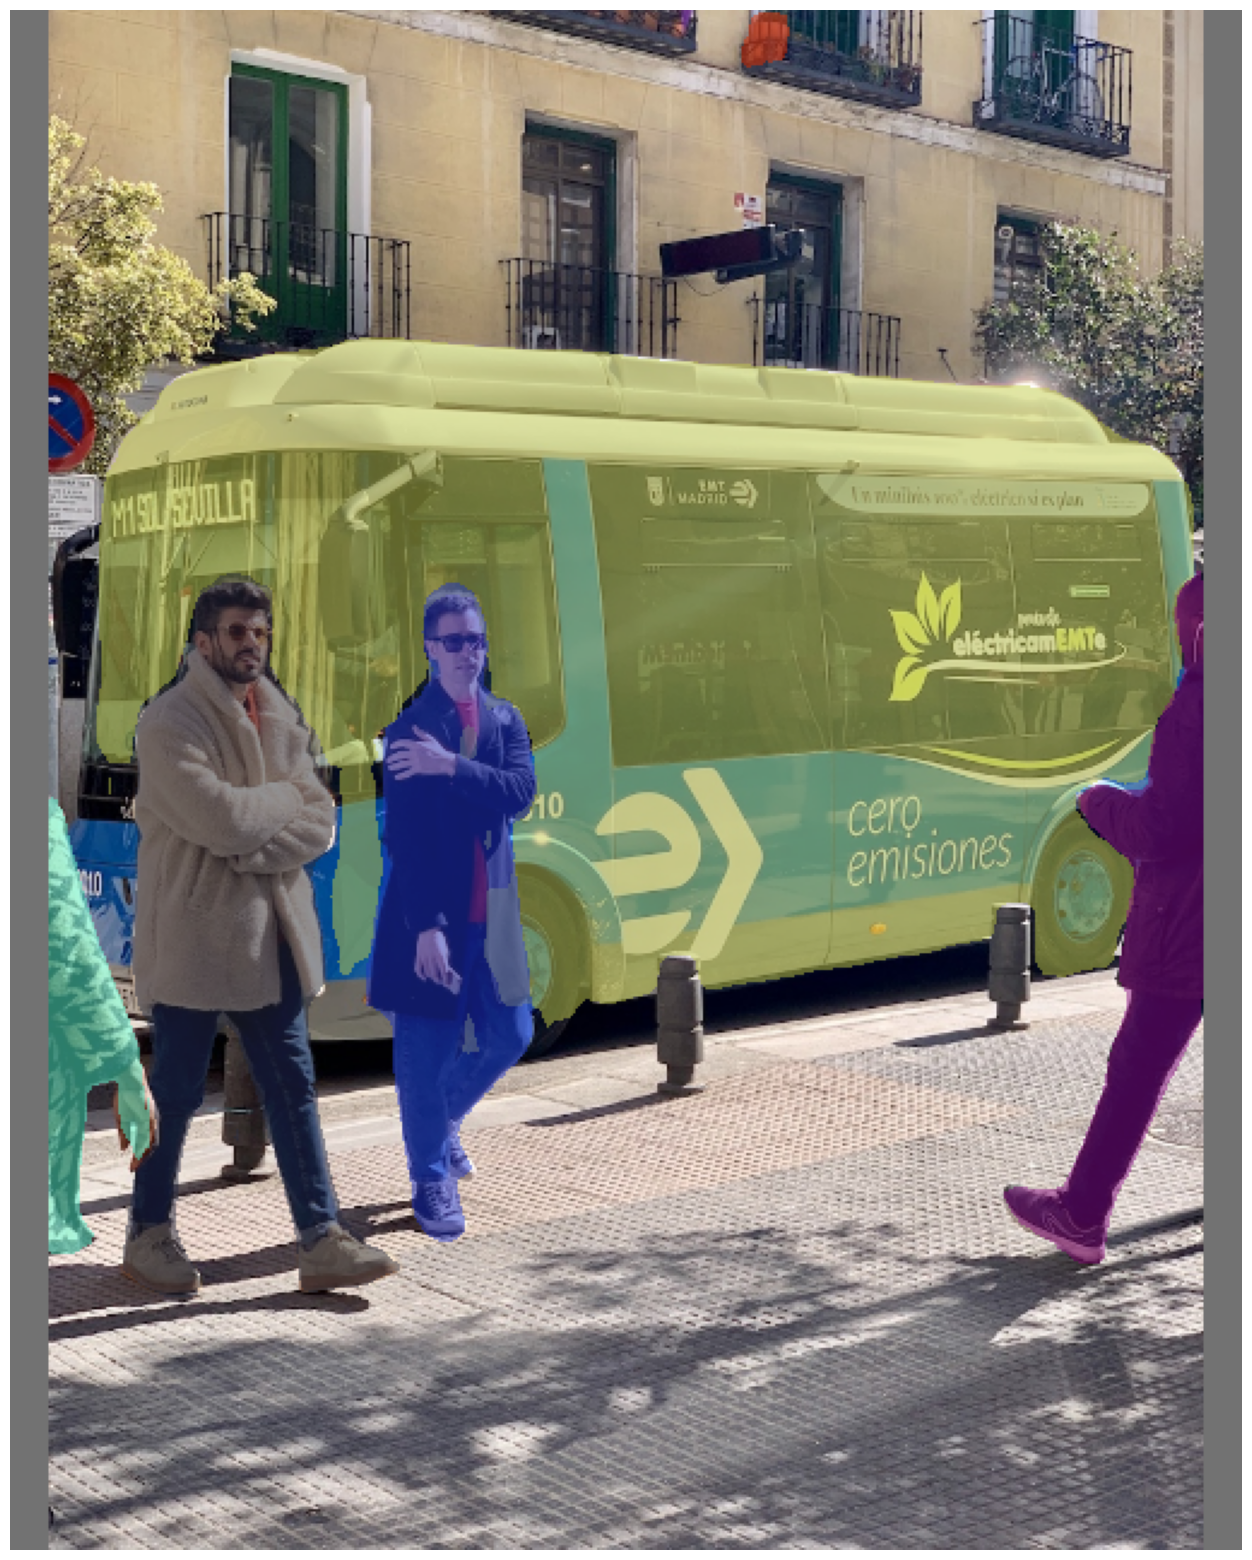

In [25]:
# coco example
%matplotlib inline
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(pnimg)
plt.show()